In [1]:
#Dependencies
from scipy import interpolate
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 500)
import csv
import plotly.graph_objects as go
import bisect

In [2]:
def Generate_UV(n,k):
    #noyau
    cyclesU = 0
    phaseU = 0
    cyclesV = 0
    phaseV = 0
    tu = np.linspace(np.pi/-2,np.pi/2,k+1)
    tv = np.linspace(np.pi/-2,np.pi/2,n+1)
    #tu = np.array([0,np.pi/6,np.pi/2])
    #tv = np.array([0,np.pi/6,np.pi/2])
    u = (np.sin(tu)+1)/2
    v = (np.sin(tv)+1)/2
    #(re)Generate
    U,V = np.meshgrid(u,v)
    VV,UU = np.meshgrid(v,u)
    
    return U,V,UU,VV

In [3]:
def Interpolate_hull(U,V,Xmin,Xmax):
    
    #source
    from scipy.interpolate import CubicSpline, PchipInterpolator
    #hull stations list
    x = [1,2,5,10,12.92,18,19]
    Bofx = [0.625,0.672,0.719,0.787,0.779,0.462,0.308]
    BWLofx = [0.240,0.397,0.649,0.560,0.550,0.174,0.071]
    Tofx = [-0.415,-0.531,-0.864,-1.026,-1.020,-0.588,-0.317]
    Dofx = [1.189,1.521,1.858,1.851,1.907,1.9,1.895]
    BCofx = [0.204,0.344,0.560,0.540,0.381,0.173,0.070]
    TBCofx = [-0.384,-0.441,-0.568,-0.630,-0.543,-0.112,0.090]
    #wetdeck stations list
    xwd = [3.7,5,6.92,10,12.92,13.92]
    bl4 = [0.800,0.764,0.717,0.703,0.683,0.760]
    dl4 = [0.960,0.781,0.76,0.604,0.725,1.400]
    bl3 = [0.80,1.279,1.730,1.758,1.45,0.763]
    dl3 = [1.045,1.051,1.076,1.099,1.110,1.39]
    bl2 = [2.9,2.717,2.498,2.428,2.400,2.428]
    bl1 = [2.9,2.9,2.9,2.9,2.9,2.9]
    dl1 = [0.960,0.861,0.684,0.604,0.629,0.674]
    #derived chine
    #BCofx = [(d*bwl/(b-bwl)-t)/(d/(b-bwl)-np.tan(15*np.pi/180)) for d,bwl,b,t in zip(Dofx,BWLofx,Bofx,Tofx)]
    #TBCofx = [np.tan(15*np.pi/180)*bc+t for bc,t in zip(BCofx,Tofx)]
    #interpo1ators
    Bofxi =CubicSpline(x,Bofx)
    BWLofxi =CubicSpline(x,BWLofx)
    Tofxi =CubicSpline(x,Tofx)
    Dofxi =CubicSpline(x,Dofx)
    BCofxi =CubicSpline(x,BCofx)
    TBCofxi =CubicSpline(x,TBCofx)
    #wetdeck interpolation
    Bl4i= CubicSpline(xwd, bl4)
    Dl4i=CubicSpline(xwd, dl4)
    Bl3i =CubicSpline(xwd,bl3)
    Dl3i =CubicSpline(xwd,dl3)
    Bl2i = CubicSpline(xwd,bl2)
    Bl1i = CubicSpline(xwd,bl1)
    Dl1i = CubicSpline(xwd,dl1)
    
    X = U*(Xmax-Xmin)+Xmin
    BW = BWLofxi(X)
    B = BCofxi(X)
    TC = TBCofxi(X)
    T = Tofxi(X)
    D = Dofxi(X)
    BD = Bofxi(X)
    
    ZWD = Dl4i(X)
    DL4 = Dl4i(X)
    BL4 = Bl4i(X)
    DL3 = Dl3i(X)
    DL1 = Dl1i(X)
    BL3 = Bl3i(X)
    BL2 = Bl2i(X)
    BL1 = Bl1i(X)
    
    #output
    return X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1

In [4]:
def Calculate_pressure_12215_7(bto,ele):
    #ajouter ZWDAX,ZSDT,  dans la définition des panneaux = éléments
    D2 = bto.LWL[0]
    D4 = bto.Tc[0]
    D9 = bto.Bc[0]
    D13 = bto.β04[0]
    D17 = bto.Type[0]
    D12 = bto.V[0]
    D5 = bto.mLDC[0]
    D40 = ele.x/bto.LWL[0]
    D46 = ele.ZTx
    D10 = bto.BBH[0]
    D26 = bto.αWD[0]
    D21 = ele.b
    D20 = ele.l
    D28 = ele.ZQx_Pan
    D41 = (0.0286*D2+0.115)*D40+0.0571*D2+0.229
    if ele.ZWDAX == '-':
        D29 = D41
    else:
        D29 = ele.ZWDAX
    
    D30 = ele.detail1
    D31 = ele.detail2
    #Panel Shape Coefficient
    D22 = 1.5-0.0003*D21
    D23 = D22*0.1*D5**0.15/(D20*D21*0.000001)**0.3
    #Boat Shape Coeefficients
    dic_category = {'A':1,'B':0.8,'C':0.6,'D':0.4}

    D42 = D28/D41
    D43 = (0.0186*D2+0.0748)*D40+0.0371*D2+0.1489
    D44 = D29/D43
    D47 = dic_category[bto.DesignCat[0]]
    if D17 == 'Planning':
        D48 = min(max(0.32*(D2/10/D9+0.084)*(50-D13)*D12*D12*D9*D9/D5,3),6)
    else:
        D48 = min(max(2.5*D2**2/(D5**0.66),1),2)
    D49 = min((1.667-0.222*D48)*D40+0.133*D48,1) 
    D50 = min((1.667-0.222*3)*D40+0.133*3,1)
    D51 = 1.3*D10/D2+0.39
    if D44>1:
        D52 = max((1/D44)**0.8,0.5)
    else:
        D52 = min((1/D44)**1.5,2)
    D53 = min(1/np.cos(D26*np.pi/180),1.5)
    if D40<0.6:
        k1=0.416*D40+0.5
    else:
        k1 = (1.25*D40)
    D54 = min(k1,1.25)
    if D17=="Planning":
        D56 = 0.1*D5/D2/D9*(1+D47**0.5*D48)
    else:
        D56 = (2*D5**0.33+18)*D48
    D57 = D56*D23*D47*D49
    D58 = max(0.3*D5**0.33+0.66*D2*D47,10*D4,7)
    D59 = 0.375*D5**0.33+9
    D60 = D59*D23*D47*D50
    D61 = 0.9*D56
    D77 = max((0.3*D5**0.33+0.66*D2*D47)*D49,7)
    D62 = max(D56*D23*D47*D54*D52*D51*D53,D77)
    D63 = min((D28-D46)/(D41-D46),1)
    D93 = max(D57,0.3*D5**0.33+0.66*D2*D47,10*D4,7)
    D103 = max(D60,5)
    D63 = min((D28-D46)/(D41-D46),1)
    D65 = min((D29-D46)/(D43-D46),1)
    D64 = max((D56-(D56-D59)*D65)*D23*D47*D50,5)

    if D31 == "Walking":
        D66 = 5
    else:
        D66 = 3.5
    if D31 == "Walking": 
         if D30 == "Front of Superstructure" or D30 == "Side of superstructure" or D30 =="Side of Open Cockpit":
            D67 = 0.67
         else:
            D67 = 0.5
    else:
         if D30 == "Front of Superstructure" or D30 == "Side of superstructure" or D30 =="Side of Open Cockpit":
            D67 = 0.5
         else:
            D67 = 0.35
    if D30 == "Front of Superstructure":
        D68 = 0.3
    elif D30 == "Side of superstructure":
        D68 = 0.4
    elif D30 == "Top of superstructures":
        D68 = 0.5
    elif D30 == "Non-protected aft side of superstructures":
        D68 = 0.6
    else:
        D68 = 1.0
    
    if D17=="Planning":
        D99 = D93-(0.4*D93-D103)*D63
    else:
        D99 = D93-(D93-D103)*D63

    D62 = max(D56*D23*D47*D54*D52*D51*D53,D77)
    D101 = max(D62,0.3*D5**0.33+0.66*D2*D47,7)
    D69 = D28-D41
    D70 = max(1-D68*D69/np.cos(D26*np.pi/180)/0.067/D2,D67)
    D71 = min((D28-D46)/(D41-D46),1.0)
    D72 = min((D28-D46)/(D29-D46),1.0)
    D73 = D57-(D57-D99)*D71
    D74 = max(D58-(D58-5)*D71,5.0)
    D75 = D57-(D57-D101)*D72
    D76 = max(D58-(D58-5)*D72,5.0)
    D94 = max(0.85*D93,5.0)
    D95 = max(D73,D74)
    D96 = max(0.85*D95,5.0)
    D97 = max(D75,D76)
    D98 = max(0.85*D97,5.0)
    D100 = max(D99*0.85,5.0)
    D101 = max(D62,0.3*D5**0.33+0.66*D2*D47,7.0)
    D102 = max(D101*0.85,5.0)
    D104 = max(D103*0.85,5.0)
    D105 = max(D59*D23*D47*D50*D70,D66)
    D106 = max(D105*0.85,5.0)
    
    
    
    return D93,D95,D101,D5,D2,D9,D47,D48,D56,D41,D97,D103,D101


In [5]:
# Coefficients 12215-5:2019
# A.5.3 Hard chine section

def kCH(α):
    
    k = 1.4936e-9*α**5 - 8.8948e-7*α**4 + 2.1076e-4*α**3 - 2.4799e-2*α**2 + 1.4484*α - 32.5783
    return k


#A.8.2 Facteurs d’ajustement de l’épaisseur pour le bordé


def k2(dim1,dim2,orientation):
    
    # invalid character '−' (U+2212 in the standard
    
    
    if orientation == 'b':
        
        if dim1/dim2 <= 2:
            a = -0.0103
            b = 0.0790
            c = -0.1441
            d = -0.2780
            e = 1.1645
            f = -0.5065
            k2 = a * (dim1/dim2)**5 + b *(dim1/dim2)**4 + c * (dim1/dim2)**3 + d * (dim1/dim2)**2 + e * (dim1/dim2) + f
        else:
            k2 = 0.5
            
     
    elif orientation == 'l':
        
         if dim1/dim2 <= 2:
            a = 0.0227
            b = -0.2497
            c = 1.0846
            d = -2.3255
            e = 2.4592
            f = -0.6860
            k2 = a * (dim1/dim2)**5 + b *(dim1/dim2)**4 + c * (dim1/dim2)**3 + d * (dim1/dim2)**2 + e * (dim1/dim2) + f
         
         else:
            k2 = 0.337
        
    
    return k2



def kSH(dim1,dim2,orientation):
    
    # invalid character '−' (U+2212 in the standard
    
    
    if orientation == 'b':
        
        if dim1/dim2 <= 2:
            a = -0.0032
            b = -0.0194
            c = 0.3325
            d = -1.2586
            e = 1.9183
            f = -0.5339
            kSH = a * (dim1/dim2)**5 + b *(dim1/dim2)**4 + c * (dim1/dim2)**3 + d * (dim1/dim2)**2 + e * (dim1/dim2) + f
        else:
            kSH = 0.52
            
     
    elif orientation == 'l':
        
         if dim1/dim2 <= 2:
            a = 0.0372
            b = -0.3841
            c = 1.5530
            d = -3.0725
            e = 2.9792
            f = -0.6767
            kSH = a * (dim1/dim2)**5 + b *(dim1/dim2)**4 + c * (dim1/dim2)**3 + d * (dim1/dim2)**2 + e * (dim1/dim2) + f
         
         else:
            kSH = 0.46
        
    
    return kSH


#A.8.2.2Facteursdecorrectiondecourbure

def kc(dim1,dim2,c1,c2):
    
    cll = c1/dim1
    cbb = c2/dim2
    
    if cll < 0.03:
        cll = 0.03
    if cbb < 0.03:
        cbb = 0.03
           
    a = np.array([-59.161,-52.061,-42.596,-35.496])
    b = np.array([34.928,30.737,25.148,20.957])
    c = np.array([-7.9717,-7.0151,-5.7396,-4.783])
    d = np.array([1.209,1.0945,0.9569,0.8474])

    #cbsurb = np.array([0.030,0.050,0.075,0.1,0.125,0.150,0.175,0.2,0.225])
    clsurl = np.array([0.030,0.060,0.080,0.1])

    fai = interpolate.interp1d(clsurl , a,kind='cubic')
    fbi = interpolate.interp1d(clsurl , b,kind='cubic')
    fci = interpolate.interp1d(clsurl , c,kind='cubic')
    fdi = interpolate.interp1d(clsurl , d,kind='cubic')
       
    ai = fai(cll)
    bi = fbi(cll)
    ci = fci(cll)
    di = fdi(cll)
   
    kc = ai*(cbb)**3 + bi*(cbb)**2 + ci*(cbb) + di

    # debug
    # xnew = np.arange(0.03, 0.1, 0.01)
    # ynew = fci(xnew)   # use interpolation function returned by `interp1d`
    # plt.plot(clsurl, c, 'o', xnew, ynew, '-')
    # plt.show()

    #cbb = np.arange(0.03, 0.225, 0.01)
    
    #ai = fai(0.045)
    #bi = fbi(0.045)
    #ci = fci(0.045)
    #di = fdi(0.045)

    #kc = ai*(cbsurb)**3 + bi*(cbsurb)**2 + ci*(cbsurb) + di
    #kcnew = ai*(cbb)**3 + bi*(cbb)**2 + ci*(cbb) + di
    #plt.plot(cbsurb, kc, 'o',cbb,kcnew,'-')
    #plt.show()
    
    return kc


# A.8 Facteurs de correction de courbures et conditions aux limites pour les raidisseurs

def kCS(clu,lu):
    
    clsurl = clu/lu
    kCS = -17.309 * (clsurl)**2 - 1.8042  * (clsurl) + 1.0717
    
    return kCS


def kBM(bcs,position):

    dic   = {'LeftEnd_FF'      : -0.083,
           'Middle_FF'         :  0.042,
           'RigthEnd_FF'       : -0.083,
           'LeftEnd_EB'        : -0.125,
           'Middle_EB'         :  0.070,
           'RigthEnd_EB'       :  0.035,
           'LeftEnd_SS'        :  0.0625,
           'Middle_SS'         :  0.125,
           'RigthEnd_SS'       :  0.0625,

        }

    strValue = position+'_'+bcs
    
    return dic[strValue]


def kSF(bcs,position):

    dic   = {'LeftEnd_FF'      :  0.50,
           'Middle_FF'         :  0.25,
           'RigthEnd_FF'       : -0.50,
           'LeftEnd_EB'        :  0.625,
           'Middle_EB'         :  0.25,
           'RigthEnd_EB'       : -0.50,
           'LeftEnd_SS'        :  0.50,
           'Middle_SS'         :  0.25,
           'RigthEnd_SS'       : -0.50,

        }

    strValue = position+'_'+bcs
    
    return dic[strValue]


#A.10 Exigences pour l’épaisseur ou le moment de flexion dû à la pression

def tp(Pressure,dim2,kc,k2b,sigmad):
    
    tp = dim2*kc*(Pressure*k2b/1000/sigmad)**0.5
    
    return tp


#A.4 Effort tranchant et moment de flexion de conception sur un panneau rectangulaire

def efforts(Pressure,dim1,dim2,c1,c2,orientation):
    
    if orientation == 'b':
        k2b = k2(dim1,dim2,orientation)
        kcb = kc(dim1,dim2,c1,c2)
        kSHb = kSH(dim1,dim2,orientation)
        Fd = kcb*kSHb*Pressure*dim2*1e-3
        Md = (1/6)*kcb*k2b*Pressure*dim2**2*1e-3
        
    return Fd,Md

def be(s,lu,bcs):
    
    dic   = {'FF'      :  2.478,
           'EB'        :  1.467,
           'SS'        :  0.825,
        }

    k1 = dic[bcs]
    # attention le rapport E/G est fixé suivant les recommendations de la norme !! 
    # à modifier pour tenir compte du E et du G du bordé associé
    k2 = 3.3
    r = (s/lu)**2
    be = (1+k1*k2*r)**(-1)*s
    
    return be


# Stiffeners efforts

def efforts_stiffeners(Pressure,s,lu,clu,bcs,orientation,position):
    
    kSFl = kSF(bcs,position)
    kBMl = kBM(bcs,position)
    kCSl = kCS(clu,lu)
    Fd =  kSFl*kCSl*Pressure*s*lu*1e-3
    Md =  kBMl*kCSl*Pressure*s*lu**2*1e-3
    
    return Fd,Md
    


In [6]:
def Bottomofx(X,V,BW,B,TC,T,D,BD):
    # Panel
    rho = ((TC-T)**2+B**2)**0.5
    alpha = np.arctan((TC-T)/B)
    Y= V*rho*np.cos(alpha)
    Z = V*rho*np.sin(alpha)+T
    return Y,Z

In [7]:
def Chineofx(X,V,BW,B,TC,T,D,BD):
    # Panel
    rho = ((BW-B)**2+TC**2)**0.5
    alpha = np.arctan(-TC/(BW-B))
    Y= V*rho*np.cos(alpha) + B
    Z = V*rho*np.sin(alpha) + TC
    return Y,Z

In [8]:
def Wallofx(X,V,BW,B,TC,T,D,BD):
    # Panel
    rho = ((BD-BW)**2+(D)**2)**0.5
    alpha = np.arctan(D/(BD-BW))
    Y= V*rho*np.cos(alpha) + BW
    Z = V*rho*np.sin(alpha)
    return Y,Z

In [9]:
def Deckofx(X,V,BW,B,TC,T,D,BD):
    # Panel
    rho = 0
    alpha = 0
    Y= 2*V*BD-BD
    Z = D
    return Y,Z

In [10]:
def InnerWall(X,V,BW,B,TC,T,D,BD,ZWD):
    # Panel
    rho = ((BD-BW)**2+(D)**2)**0.5
    alpha = np.arctan(D/(BD-BW))
    Y= V*rho*np.cos(alpha) + BW
    Z = V*rho*np.sin(alpha)
    return -Y,Z

In [11]:
def InnerWall2(X,V,BW,B,TC,T,D,BD,ZWD):
    # Panel
    rho = (((ZWD+D*BW/(BD-BW))/(D/(BD-BW))-BW)**2+ZWD**2)**0.5
    alpha = np.arctan(D/(BD-BW))
    Y= V*rho*np.cos(alpha) + BW
    Z = V*rho*np.sin(alpha)
    return -Y,Z

In [12]:
def InnerWall2Wetdeck(X,V,BW,B,TC,T,D,BD,ZWD,DL3,DL4,BL3,BL4):
    # #outside panels @angle
    # bi = np.linspace(BL4,BL3,nwetdeck+1) #n panels requires n+1 stations (minimum 1)
    rn = (DL3-DL4) #numérateur du coefficient directeur dy
    rd = (BL3-BL4) #dénominateur du coefficient directeur dx
    r = rn/rd #coefficient directeur
    p = DL4-BL4*r # intersection à l'origine
    # ti = [r*(b+bp)/2+p for b,bp in zip(bi[:-1],bi[1:]) ]
    # L1 = (xi[i+1]-xi[i])*1000
    # L2 = (rn**2+rd**2)**0.5/nwetdeck*1000

    rho = (rn**2+rd**2)**0.5
    alpha = np.arctan(r)
    Y= V*rho*np.cos(alpha) + BL4
    Z = V*rho*np.sin(alpha) + DL4
    return -Y,Z

In [13]:
def Wetdeck1(X,V,BW,B,TC,T,D,BD,ZWD,BL2,BL3,DL3):
    rn = 0 #numérateur du coefficient directeur dy=0 (FLAT)
    rd = (BL2-BL3) #dénominateur du coefficient directeur dx
    r = rn/rd #coefficient directeur
    #changement de repère
    rho = (rn**2+rd**2)**0.5
    alpha = np.arctan(r)
    Y = V*rho*np.cos(alpha) + BL3
    Z = V*rho*np.sin(alpha) + DL3 
    return -Y,Z

In [14]:
def Wetdeck2(X,V,BW,B,TC,T,D,BD,DL1,DL3,BL1,BL2,BL3):
    rn = (DL1-DL3) #numérateur du coefficient directeur dy=0 (FLAT)
    rd = (BL1-BL2) #dénominateur du coefficient directeur dx
    r = rn/rd #coefficient directeur
    #changement de repère
    rho = (rn**2+rd**2)**0.5
    alpha = np.arctan(r)
    Y = V*rho*np.cos(alpha) + BL2
    Z = V*rho*np.sin(alpha) + DL3
    return -Y,Z

In [15]:
def Draw(X,Y,Z,colorscale,symetryY):
    data = []
    out = go.Surface(x=X, y=Y, z=Z,colorscale=colorscale,opacity=0.5)
#     line_marker = dict(color='#101010', width=4)
#     for xx, yy, zz in zip(X, Y, Z):
#         out = go.Scatter3d(x=xx, y=yy, z=zz, mode='lines', line=line_marker, name='')
#         data += [out]
    return out

In [16]:
def Built_object(obj):
    
    #subgrid markers
    line_marker = dict(color='#101010', width=4)

    n,k,Xmin,Xmax,regions,U,V,UU,VV = obj
    
    #initialize output
    data = []
    
    
    #object surface
    for i in range(len(regions)):
        X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1 = Interpolate_hull(U,V,Xmin,Xmax)
        selection = regions[i]
        if selection[0] == 'A':
            #map object + symétrique
            Y,Z = Bottomofx(X,V,BW,B,TC,T,D,BD)
            colorscale='blues_r'
        if selection[0] == 'B':
            #map object + symétrique
            Y,Z = Chineofx(X,V,BW,B,TC,T,D,BD)
            colorscale='gray_r'
        if selection[0] == 'C':
            #map object
            Y,Z = Wallofx(X,V,BW,B,TC,T,D,BD)
            colorscale='reds_r'
        if selection[0] == 'D':
            #map object
            Y,Z = Deckofx(X,V,BW,B,TC,T,D,BD)
            colorscale='oranges_r'
        if selection[0] == 'E':
            Y,Z = InnerWall(X,V,BW,B,TC,T,D,BD,ZWD)
            colorscale='reds_r'
        if selection[0] == 'F':
            Y,Z = InnerWall2(X,V,BW,B,TC,T,D,BD,ZWD)
            colorscale='reds_r'
        if selection[0] == 'G':
            Y,Z = InnerWall2Wetdeck(X,V,BW,B,TC,T,D,BD,ZWD,DL3,DL4,BL3,BL4)
            colorscale='greys_r'
        if selection[0] == 'H':  
            Y,Z = Wetdeck1(X,V,BW,B,TC,T,D,BD,ZWD,BL2,BL3,DL3)
            colorscale='greys_r'
        if selection[0] == 'I':  
            Y,Z = Wetdeck2(X,V,BW,B,TC,T,D,BD,DL1,DL3,BL1,BL2,BL3)
            colorscale='greys_r'
        #draw object
        object =  Draw(X,Y,Z,colorscale,'Y')
        data += [object]
        for xx, yy, zz in zip(X, Y, Z):
            data += [go.Scatter3d(x=xx, y=yy, z=zz, mode='lines', line=line_marker, name='')]
        if selection[-1] == 's':
                object =  Draw(X,-Y,Z,colorscale,'Y')
                #append object
                data += [object]
                for xx, yy, zz in zip(X, Y, Z):
                    data += [go.Scatter3d(x=xx, y=-yy, z=zz, mode='lines', line=line_marker, name='')]
    
    #object surface
    for i in range(len(regions)):
        XX,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1 = Interpolate_hull(UU,VV,Xmin,Xmax)
        selection = regions[i]
        if selection[0] == 'A':
            #map object + symétrique
            YY,ZZ = Bottomofx(XX,VV,BW,B,TC,T,D,BD)
            colorscale='blues_r'
        if selection[0] == 'B':
            #map object + symétrique
            YY,ZZ = Chineofx(XX,VV,BW,B,TC,T,D,BD)
            colorscale='gray_r'
        if selection[0] == 'C':
            #map object
            YY,ZZ = Wallofx(XX,VV,BW,B,TC,T,D,BD)
            colorscale='reds_r'
        if selection[0] == 'D':
            #map object
            YY,ZZ = Deckofx(XX,VV,BW,B,TC,T,D,BD)
            colorscale='oranges_r'
        if selection[0] == 'E':
            YY,ZZ = InnerWall(XX,VV,BW,B,TC,T,D,BD,ZWD)
            colorscale='reds_r'
        if selection[0] == 'F':
            YY,ZZ = InnerWall2(XX,VV,BW,B,TC,T,D,BD,ZWD)
            colorscale='reds_r'
        if selection[0] == 'G':
            YY,ZZ = InnerWall2Wetdeck(XX,VV,BW,B,TC,T,D,BD,ZWD,DL3,DL4,BL3,BL4)
            colorscale='greys_r'
        if selection[0] == 'H':  
            YY,ZZ = Wetdeck1(XX,VV,BW,B,TC,T,D,BD,ZWD,BL2,BL3,DL3)
            colorscale='greys_r'
        if selection[0] == 'I':  
            YY,ZZ = Wetdeck2(XX,VV,BW,B,TC,T,D,BD,DL1,DL3,BL1,BL2,BL3)
            colorscale='greys_r'
        for xx, yy, zz in zip(XX, YY, ZZ):
            data += [go.Scatter3d(x=xx, y=yy, z=zz, mode='lines', line=line_marker, name='')]
        if selection[-1] == 's':
            for xx, yy, zz in zip(XX, YY, ZZ):
                    data += [go.Scatter3d(x=xx, y=-yy, z=zz, mode='lines', line=line_marker, name='')]
        

    
    return data,X,Y,Z,XX,YY,ZZ

In [17]:
def Intersect_UV(obj1,obj2):
    #obj1 Master obj2 Client
    n1,k1,min1,max1,region1 = obj1
    n2,k2,min2,max2,region2 = obj2
    #noyaux1
    cyclesU2 = 0
    phaseU2 = 0
    cyclesV2 = 0
    phaseV2 = 0
    tu2 = np.linspace(np.pi/-2,np.pi/2,k2+1)
    tv2 = np.linspace(np.pi/-2,np.pi/2,n2+1)
    #may need a remove doubles here
    u2 = (np.sin(tu2)+1)/2
    v2 = (np.sin(tv2)+1)/2
    #convert in X-space
    x21 = u2*(max2-min2)+min2
    #convert back in t-space
    u21 = (x21-min1)/(max1-min1)
    tu21 = np.arcsin(2*u21-1)
    #noyaux1
    cyclesU1 = 0
    phaseU1 = 0
    cyclesV1 = 0
    phaseV1 = 0
    tu1 = np.linspace(np.pi/-2,np.pi/2,k1+1)
    tv1 = np.linspace(np.pi/-2,np.pi/2,n1+1)
    #intersect noyaux 2>1
    tu1 = np.append(tu1, tu21) 
    tu1 = np.sort(tu1)
    #may need a remove doubles here
    u1 = (np.sin(tu1)+1)/2
    v1 = (np.sin(tv1)+1)/2
    #(re)Generate
    U1,V1 = np.meshgrid(u1,v1)
    VV1,UU1 = np.meshgrid(v1,u1)
    U1,V1 = np.meshgrid(u1,v1)
    VV1,UU1 = np.meshgrid(v1,u1)

    #(re)Generate
    U2,V2 = np.meshgrid(u2,v2)
    VV2,UU2 = np.meshgrid(v2,u2)
    U2,V2 = np.meshgrid(u2,v2)
    VV2,UU2 = np.meshgrid(v2,u2)
    

    return U1,V1,UU1,VV1,U2,V2,UU2,VV2

In [18]:
def Generate_object(obj):
    #initiate
    data = []
    objects = []
    n,k,Xmin,Xmax,regions = obj
    #iterate on objects
    for i in range(len(regions)):
        region = regions[i]
        #generate map
        U,V,UU,VV = Generate_UV(n,k)
        obj = [n,k,Xmin,Xmax,region,U,V,UU,VV]
        out,X,Y,Z,XX,YY,ZZ = Built_object(obj)
        #store data
        data += out
        obj += [X,Y,Z,XX,YY,ZZ]
        objects += [obj]
    return objects,data

In [19]:
def Link_object(obj1,obj2):
    #initiate
    data = []
    n1,k1,Xmin1,Xmax1,regions1 = obj1
    n2,k2,Xmin2,Xmax2,regions2 = obj2
    #generate maps
    U1,V1,UU1,VV1,U2,V2,UU2,VV2 = Intersect_UV(obj1,obj2)
    #initialize output
    data = []
    #update station number object1
    obj1 = [n1,k1+k2,Xmin1,Xmax1,regions1,U1,V1,UU1,VV1]
    obj2 = [n2,k2,Xmin2,Xmax2,regions2,U2,V2,UU2,VV2]
    out1,X1,Y1,Z1,XX1,YY1,ZZ1  = Built_object(obj1)
    out2,X2,Y2,Z2,XX2,YY2,ZZ2  = Built_object(obj2)
    #store data
    data += out1
    data += out2
    obj1 += [X1,Y1,Z1,XX1,YY1,ZZ1]
    obj2 += [X2,Y2,Z2,XX2,YY2,ZZ2]
    
    return data,obj1,obj2

In [20]:
def Center_UV(lst):
    out = []
    for item in lst:
        s = item[:,:-1]+item[:,1:]
        ss = s[:-1,:]+s[1:,:]
        out += [ss/4]
    return out

In [21]:
def Differentiate_UV(lst):
    out = []
    for item in lst:
        s =  item[1:,1:]-item[:-1,:-1]
        out += [(s**2)**0.5]
    return out

In [22]:
def Extract_panels(objects,panels_):
    #iterate on objects
    for k in range(len(objects)):
        
        obj = objects[k]
        # WORK ZONE _ACTIVE FOR DEVELOPPEMENT GET ALL DATA FROM OBJECT
        n1,k1,Xmin1,Xmax1,regions,U1,V1,UU1,VV1,X1,Y1,Z1,XX1,YY1,ZZ1 = obj
        #iterate on regions
        for i in range(len(regions)):
            if regions[i]=='s':
                region1 = regions[i-1]
                sym = -1
                tag = 's'
            else:
                region1 = regions[i]
                sym = 1
                tag = ''
            #Create center
            CX,CY,CZ = Center_UV([X1,Y1,Z1])
            [CX,CY,CZ] = [a.flatten() for a in [CX,CY,CZ]]
            #Get information at center
            X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1 = Interpolate_hull(U1,V1,Xmin1,Xmax1)
            X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1 = Center_UV([X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1])
            X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1 = [a.flatten() for a in [X,BW,B,TC,T,D,BD,ZWD,DL4,BL4,DL3,DL1,BL3,BL2,BL1]]
            DX,DY,DZ = Differentiate_UV([X1,Y1,Z1])
            DX,DY,DZ = [a.flatten() for a in [DX,DY,DZ]]
            #Write Panel

            #iterate on panels
            for ind in range(len(X)):
                L = len(panels_)
                #L = L+1
                panels_.loc[L+1,'Reference'] = 'obj' + str(k) +'-'+str(ind)+tag
                panels_.loc[L+1,'Pos_elem'] = region1
                panels_.loc[L+1,'x'] = CX[ind]
                panels_.loc[L+1,'y'] = CY[ind]*sym
                panels_.loc[L+1,'z'] = CZ[ind]
                if (region1 == 'A') or (region1 == 'B') or (region1 == 'C') or (region1 == 'D') or (region1 == 'E'): 
                    panels_.loc[L+1,'ZWDAX'] = '-'
                else:
                    panels_.loc[L+1,'ZWDAX'] = ZWD[ind]
                panels_.loc[L+1,'ZTx'] = T[ind]
                panels_.loc[L+1,'ZQx_Pan'] = CZ[ind]
                L1 = (DX[ind]**2)**(0.5)*1000
                L2 = (DY[ind]**2 + DZ[ind]**2)**(0.5)*1000
                if L1>L2:
                        panels_.loc[L+1,'b'] = L2
                        panels_.loc[L+1,'l'] = L1
                        panels_.loc[L+1,'Orientation'] = 'b'
                else:
                        panels_.loc[L+1,'b'] = L1
                        panels_.loc[L+1,'l'] = L2
                        panels_.loc[L+1,'Orientation'] = 'l'
                panels_.loc[L+1,'cb'] = 0
                panels_.loc[L+1,'cl'] = 0
                panels_.loc[L+1,'detail1'] = '-'
                panels_.loc[L+1,'detail2'] = "-"

    return panels_

In [23]:
def Analyse_panels(bto,panels_):
    sigmad = 102
    
    for i in range(len(panels_)):
        #initiate
        ele = panels_.loc[i+1]
        #get panel characteristics
        dim1 = panels_.loc[i+1,'l']
        dim2 = panels_.loc[i+1,'b']
        c1 = panels_.loc[i+1,'cl']
        c2 = panels_.loc[i+1,'cb']
        orientation = panels_.loc[i+1,'Orientation']
        coef = kc(dim1,dim2,c1,c2)
        k2b = k2(dim1,dim2,orientation)
        #calculate pressures
        D93,D95,D101,D5,D2,D9,D47,D48,D56,D41,D97,D103,D101 = Calculate_pressure_12215_7(bto,panels_.loc[i+1])
        
        if ele.Pos_elem == 'A':
            panels_.loc[i+1,'P calc'] = D93
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            #write panel analysis
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'B':
            panels_.loc[i+1,'P calc'] = D93
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41

        if ele.Pos_elem == 'C':
            panels_.loc[i+1,'P calc'] = D95
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'D':
            panels_.loc[i+1,'P calc'] = D103
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'E':
            panels_.loc[i+1,'P calc'] = D97
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'F':
            panels_.loc[i+1,'P calc'] = D97
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'G':
            panels_.loc[i+1,'P calc'] = D101
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'H':
            panels_.loc[i+1,'P calc'] = D101
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
            
        if ele.Pos_elem == 'I':
            panels_.loc[i+1,'P calc'] = D101
            #write panel analysis
            Thickness = tp(D95,dim2,coef,k2b,sigmad)
            panels_.loc[i+1,'Thickness_min'] = Thickness
            panels_.loc[i+1,'ZSTMX'] = D41
  
    return panels_

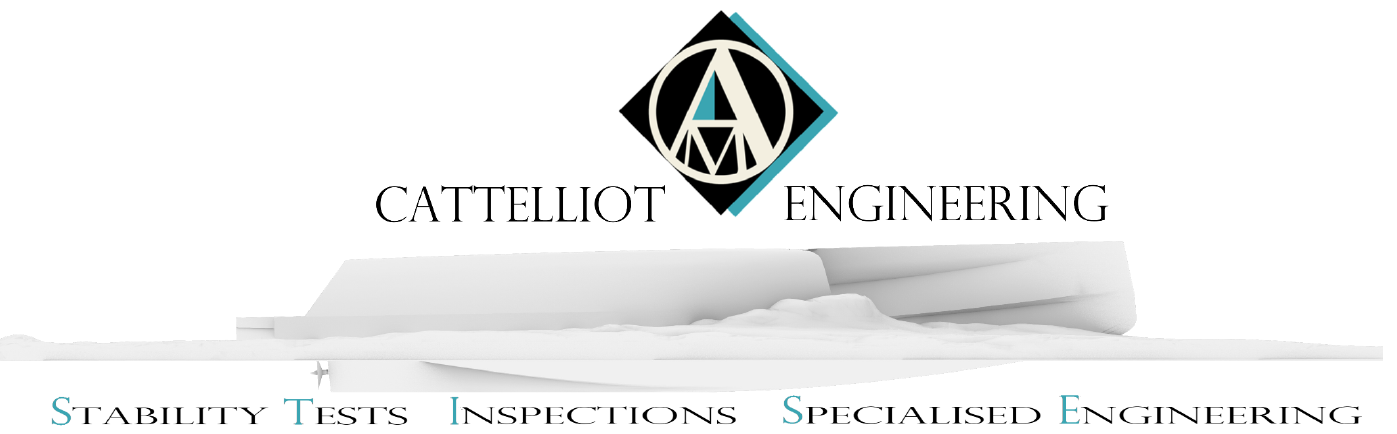

code : <b>A8663</b><br>
date : <b>2023/05/31</b>

# SANTORINI - ISO 12215 Assessment 

## Content

Thicknesses of panels according to <b>ISO 12215-7:2019</b> <i>Small craft — Hull construction and scantlings — Part 7: Scantlings determination of multihulls</i> and <b>ISO 12215-5:2019</b> <i>Small craft — Hull construction and scantlings — Part 5: Design pressures for monohulls, design stresses, scantlings determination</i>

## Inputs

Dimensions are taken according to the 3D model <i> Santo Construction pour Alan.3dm</i>.
Panel material is taken as being equivalent to <b>EN AW-5086</b>. The <b>welded</b> mechanical properties are used, according to <b>ISO 12215:2008</b> <i>Small craft - Hull construction and scantlings Part 5: Design pressures for monohulls, design stresses, scantlings determination</i>.

In [24]:
#initialize data
objects = []
data=[]

In [25]:
#initialize panels
dic_panels = ['Reference','Pos_elem','x','y','z','ZQx_Pan','ZWDAX','ZTx','ZSTMX','b','l','cb','cl','P calc','Orientation']
panels_ = pd.DataFrame( columns = dic_panels)

In [26]:
#initialize materials
dic_boat = ['Reference','Type','DesignCat','LWL','LWD','XWD','Tc','mLDC','BH','BCB','Bc','BBH','BWL','V','αWD','β04']
boat=pd.DataFrame( columns = dic_boat)

In [52]:
#define boat
boat.loc[0] = ['Santorini','Motor','A',20.00,9.3,3.7,1.050,29000,7.374,5.675,1.6,4.31,1.6,12.5,30.,15.]
res = boat
trace5 = go.Table(
    header=dict(values=res.columns,
                fill_color='#b39732',
                line_color='white',
                font=dict(color='white'),
                #align=['left','left','left','center','center','center'],
               ),
    cells=dict(#values=materiauTable.transpose().values.tolist(),
                values = res.transpose().values.tolist(),
                fill_color='#3ba7b3',
                line_color='white',
                font=dict(color='white'),
                #align=['left','left','center'],
                #format = [None,None,None,None],
                ),
    #columnwidth = [110,150,550]
    )
layout5 = go.Layout(title='Boat dimensions',
                    #width=800,
                    height=100,
                    margin=dict(
                                l=0,
                                r=0,
                                b=0,
                                t=50,
                                pad=0
                                ),
                   )
boat_table = go.FigureWidget(data=[trace5], layout=layout5)
#boat_table.show(renderer='notebook')
boat_table.show()

<b>LWL</b>  [m]    Length of waterline according to ISO 8666<br>
<b>LWD</b>  [m]    Length of the wet deck measured parallel to LWL<br>
<b>XWD</b>  [m]    Longitudinal distance between AP and the aft wetdeck station<br>
<b>TC</b>   [m]    Max canoe body depth<br>
<b>mLDC</b> [kg]   Mass of displacement in fully loaded condition according to ISO 8666<br>
<b>BH</b>   [m]    Beam of hull<br>
<b>BCB</b>  [m]    Beam between centres of buoyancy<br>
<b>BC</b>   [m]    Chine beam<br>
<b>BBH</b>  [m]    Beam between hull<br>
<b>BWL</b>  [m]    Beam between hull<br>
<b>V</b>    [kts]  Boat maximum speed in fully loaded condition (mLDC)<br>
<b>αWD</b>  [deg]  Longitudinal angle of wet deck/crossbeam front<br>
<b>β04</b>  [m]    Deadrise at 40% of LWL<br>

In [28]:
# #CREATE LINKED OBJECT
# obj1 = [1,9,0.0,20.0,['As','Bs','C','D']]
# obj2 = [1,3,3.7,3.7+9.3,['F','G','H','I']]
# out,obj1,obj2 = Link_object(obj1,obj2)
# data +=out
# #store
# objects += [obj1]+[obj2]

# # Multiple object management is not implemented 
# # To be implemented the same way as Generate_objects
# # ---------------------------------------------------------------------------
# # ValueError                                Traceback (most recent call last)
# # <ipython-input-201-3dafb4cc1d68> in <module>
# # ----> 1 Extract_panels(objects,panels_)
# #       2 Analyse_panels(boat,panels_)

# # <ipython-input-168-fd0afe649e8a> in Extract_panels(objects, panels_)
# #       6         obj = objects[k]
# #       7         # WORK ZONE _ACTIVE FOR DEVELOPPEMENT GET ALL DATA FROM OBJECT
# # ----> 8         n1,k1,Xmin1,Xmax1,regions,U1,V1,UU1,VV1,X1,Y1,Z1,XX1,YY1,ZZ1 = obj
# #       9 
# #      10         #iterate on regions

# # ValueError: not enough values to unpack (expected 15, got 5)



In [29]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 0 #minimum
Xmax = 3.7 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','C','D','E']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [30]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 3.7 #minimum
Xmax = 6.0 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','C','D','F']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [31]:
#HULL
#interpolations stations
n = 2
k = 1
Xmin = 6.0 #minimum
Xmax = 8.3 #maximum 
obj = [n,k,Xmin,Xmax,['Bs','C','F']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [32]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 6.0 #minimum
Xmax = 8.3 #maximum 
obj = [n,k,Xmin,Xmax,['As','D']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [33]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 8.3 #minimum
Xmax = 10.65 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','C','D','F']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [34]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 10.65 #minimum
Xmax = 12.1 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','D']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [35]:
#HULL
#interpolations stations
n = 2
k = 1
Xmin = 10.65 #minimum
Xmax = 12.1 #maximum 
obj = [n,k,Xmin,Xmax,['C','F']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [36]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 12.1 #minimum
Xmax = 13.90 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','D']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [37]:
#HULL
#interpolations stations
n = 2
k = 1
Xmin = 12.1 #minimum
Xmax = 13.90 #maximum 
obj = [n,k,Xmin,Xmax,['C','F']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [38]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 13.90 #minimum
Xmax = 15.90 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','D']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [39]:
#HULL
#interpolations stations
n = 2
k = 1
Xmin = 13.90 #minimum
Xmax = 15.90 #maximum 
obj = [n,k,Xmin,Xmax,['C','E']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [40]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 15.90 #minimum
Xmax = 19.0 #maximum 
obj = [n,k,Xmin,Xmax,['As','Bs','D']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [41]:
#HULL
#interpolations stations
n = 2
k = 1
Xmin = 15.90 #minimum
Xmax = 19.0 #maximum 
obj = [n,k,Xmin,Xmax,['C','E']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [42]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 3.7 #minimum
Xmax = 6.0 #maximum 
obj = [n,k,Xmin,Xmax,['F','G','H','I']]
obj, out = Generate_object(obj)
data += out
objects += obj

<ipython-input-12-0b21962a0d9f>:6: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-14-ac938a520889>:4: RuntimeWarning:

divide by zero encountered in true_divide



In [43]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 6.0 #minimum
Xmax = 8.3 #maximum 
obj = [n,k,Xmin,Xmax,['F','G','H','I']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [44]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 8.3 #minimum
Xmax = 10.65 #maximum 
obj = [n,k,Xmin,Xmax,['F','G','H','I']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [45]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 10.65 #minimum
Xmax = 12.1 #maximum 
obj = [n,k,Xmin,Xmax,['F','G','H','I']]
obj, out = Generate_object(obj)
data += out
objects += obj

In [46]:
#HULL
#interpolations stations
n = 1
k = 1
Xmin = 12.1 #minimum
Xmax = 13.90 #maximum 
obj = [n,k,Xmin,Xmax,['F','G','H','I']]
obj, out = Generate_object(obj)
data += out
objects += obj

## Outputs

Panels are defined in the following zones : <b>A</b> Bottom, <b>B</b> Bottom under waterline, <b>C</b> Outer Wall, <b>D</b> Deck, <b>E</b> Inner Wall outside wetdeck,  <b>F</b> Inner Wall in way of wetdeck,  <b>G,H,I</b> Wetdeck. The <b>design pressures</b> and the <b>minimum thicknesses</b> are calculated for each panel and reported down below (one panel per line, scroll to display all entries).  

In [47]:

panels_ = Extract_panels(objects,panels_)
panels_ = Analyse_panels(boat,panels_)

In [48]:
res = panels_
trace4 = go.Table(
    header=dict(values=res.columns,
                fill_color='#b39732',
                line_color='white',
                font=dict(color='white'),
                #align=['left','left','left','center','center','center'],
               ),
    cells=dict(#values=materiauTable.transpose().values.tolist(),
                values = res.transpose().values.tolist(),
                fill_color='#3ba7b3',
                line_color='white',
                font=dict(color='white'),
                #align=['left','left','center'],
                format = [None,None,".3f",".3f",".3f",".3f",".3f",".3f",".3f",".0f",".0f",".0f",".0f",".1f","","","",".1f"],
                ),
    #columnwidth = [110,150,550]
    )
layout4 = go.Layout(title='ISO 12215 Panel Analysis',
                    #width=800,
                    height=500,
                    margin=dict(
                                l=0,
                                r=0,
                                b=0,
                                t=50,
                                pad=0
                                ),
                   )
panel_table = go.FigureWidget(data=[trace4], layout=layout4)
#panel_table.show(renderer='notebook')
panel_table.show()

<b>Pos_element</b>   []    Panel zone<br>
<b>x</b>   [m]    Longitudinal position of the center from AP<br>
<b>y</b>   [m]    Transversal position of the center from hull center plane<br>
<b>z</b>   [m]    Vertical position of the center from WL<br>
<b>ZQX_panel</b>   [m]    Height of point x Q above WL at section x<br>
<b>ZWDAX</b>   [m]    Height above WL of the theoretical wet deck height at section x<br>
<b>ZTX</b>   [m]    Height of local hard chine above WL at section x<br>
<b>ZSDTM</b>  [m]  Height above WL of the theoretical side/deck limit<br>
<b>b</b>  [mm]  Shorter dimension of panel<br>
<b>l</b>  [mm]  Longer dimension of panel<br>
<b>cb</b>  [mm]  Curvature of the panel along the shorter edge<br>
<b>cl</b>  [mm]  Curvature of the panel along the longer edge<br>
<b>P</b>  [kPa]  Design pressure<br>
<b>Thickness</b>  [mm]  Minimum required thickness<br>

In [49]:
#display object
fig = go.FigureWidget(data=data)
fig.add_trace(go.Scatter3d(
    x=panels_['x'],
    y=panels_['y'],
    z=panels_['z'],
    mode="text",
    name="iso12215-7",
    text=panels_['Reference'],
    textposition="middle center",
    textfont=dict(color="black",size=12),
))
fig.update_layout(scene_aspectmode='data',
                  title = 'Graphical representation'
                  #width=800, height=800,
                 )
fig.update_traces(showscale=False, selector=dict(type='surface'))
fig.update(layout_showlegend=False)
#fig.show(renderer='notebook')

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(8,48,107)'], [0.125, 'rgb(8,81,156)'],
                …

In [50]:
import ipywidgets as widgets

def change_information_display(b):
    global panels
    if w.value == 'Reference':
        fig.data[-1].text =panels_['Reference']
        fig.data[-1].textfont.size = 12
    if w.value == 'Pression':
        fig.data[-1].text = ["{:.1f}".format(a)+"kPa" for a in panels_['P calc']]
        fig.data[-1].textfont.size = 18
    if w.value == 'Thickness':
        fig.data[-1].text = ["{:.1f}".format(a)+"mm" for a in panels_['Thickness_min']]
        fig.data[-1].textfont.size = 18

style = {'description_width': 'initial'}
w = widgets.ToggleButtons(
    options=['Reference', 'Pression', 'Thickness'],
    description='Choose information to display',
    disabled=False,
    style=style,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Panel reference', 'iso 12215-7 Pressure', 'iso12215-5 Thickness'],
#     icons=['check'] * 3
)
w.observe(change_information_display)
w

ToggleButtons(description='Choose information to display', options=('Reference', 'Pression', 'Thickness'), sty…

## Informations

Report created by <b>A.C.E. CATTELLIOT ENGINEERING</b>, 28 rue Lavoisier, 17440 AYTRE, FRANCE. An interactive version of this report is available [here](https://mybinder.org/v2/gh/Alan-Cattelliot/A8663.git/main?urlpath=%2Fvoila%2Frender%2FSuper_boat.ipynb). <i>This external link automatically create a protected virtual machine. If the machine takes too long to start, please refresh the page in   

